In [1]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

import scipy as sp
from scipy.linalg import eig 
import matplotlib


from contextlib import suppress

import itertools

from tqdm import tqdm

import cassiopeia.TreeSolver.post_process_tree as ppt
from cassiopeia.Analysis import reconstruct_states
from cassiopeia.TreeSolver.Node import Node
import cassiopeia.TreeSolver.compute_meta_purity as cmp
from cassiopeia.Analysis import small_parsimony

from utilities import seeding_patterns


from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import umap
import numba


## Read in lineage groups

In [2]:
lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

home_dir = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/'


lg_to_tree = {}
lg_to_cm = {}
for tree_dir in tqdm(os.listdir(home_dir)):
    tree_dir = home_dir + tree_dir + "/"

    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.pkl" in fp and "tree" in fp and 'nj' not in fp]
    cms = [fp for fp in os.listdir(tree_dir) if 'character_matrix.alleleThresh.txt' in fp]

    if len(fps) > 0:
        
        try:
            tree = pic.load(open((tree_dir + fps[0]), 'rb'))
            lg_to_tree[int(lg)] = tree
            
            lg_to_cm[int(lg)] = pd.read_csv(tree_dir + cms[0], sep='\t', index_col = 0)
        except:
            continue

100%|██████████| 113/113 [01:18<00:00,  1.44it/s]


## Form Transition Matrices

In [44]:
count_arrs = []
lgs = []
diag_density = []
LL_density = []
M1_density = []
M2_density = []
LL_stay = []
RW_stay = []
RE_stay = []
Liv_stay = []
M1_stay = []
M2_stay = []

bidirectional_reseeding = {}
to_drop = [33, 5, 69, 39, 38, 41, 75, 16, 18, 50, 53, 87, 88, 25, 93, 65, 81]

for _lg in tqdm(lg_to_tree.keys()):
    
    if _lg in to_drop:
        continue
    
    lg = lg_to_tree[_lg]
    cm = lg_to_cm[_lg]

    plg = lg.post_process(cm).network
    
    bidirectional_reseeding[_lg] = seeding_patters.detect_bidirectional_reseeding(plg, lg_meta['sampleID'], NUM_ITER=100)
    
    count_arr = reconstruct_states.fitch_count(plg, lg_meta['sampleID'])
    tot = np.sum(count_arr.sum())
    diag_density.append(np.sum([count_arr.iloc[i, i] / tot for i in range(count_arr.shape[0])]))

    LL_stay.append(count_arr.loc['LL', "LL"] / tot)
    RW_stay.append(count_arr.loc['RW', "RW"] / tot)
    RE_stay.append(count_arr.loc['RE', "RE"] / tot)
    M1_stay.append(count_arr.loc['M1', "M1"] / tot)
    M2_stay.append(count_arr.loc['M2', "M2"] / tot)
    Liv_stay.append(count_arr.loc['Liv', "Liv"] / tot)

    np.fill_diagonal(count_arr.values,0)
    tot = np.sum(count_arr.sum())
    LL_density.append(np.sum([count_arr.loc['LL', i] / tot for i in count_arr.columns]))
    M1_density.append(np.sum([count_arr.loc['M1', i] / tot for i in count_arr.columns]))
    M2_density.append(np.sum([count_arr.loc['M2', i] / tot for i in count_arr.columns]))

    count_arr = count_arr.apply(lambda x: x / max(1, x.sum()), axis=1)

    count_arrs.append(count_arr)
    lgs.append(_lg)
        
        
lg_to_countarr = dict(zip(lgs, count_arrs))    

 27%|██▋       | 27/100 [02:56<11:21,  9.33s/it]/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 100/100 [10:10<00:00,  6.11s/it]


In [51]:
# create a dataframe to track different topologies
topo_df = pd.DataFrame(index = lgs)
topo_df['PrimarySeeding'] = False
topo_df['SeedingCascade'] = False
topo_df['ParallelSeeding'] = False
topo_df['Reseeding'] = False
topo_df['BiDirectionalReseeding'] = False
topo_df['SeedingCascade'] = False

for n in lgs:
    transmat = lg_to_countarr[n]
    
    
    # record seeding cascade
    for i in transmat.index:
        if i != 'LL':
            for j in transmat.columns:
                if j != 'LL' and transmat.loc[i, j] > 0:
                    topo_df.loc[n, 'SeedingCascade'] = True
        
    topo_df.loc[n, 'BiDirectionalReseeding'] = bidirectional_reseeding[n]
    
    # detect reseeding
    if np.sum(transmat['LL']) > 0:
        topo_df.loc[n, 'Reseeding'] = True
        topo_df.loc[n, 'BiDirectionalReseeding'] = True
                
    # record primary seeding
    if np.sum(transmat.sum()) > 0 or ("LL" not in lg_meta.loc[lg_meta['LineageGroup'] == n, 'sampleID'].unique()):
        topo_df.loc[n, 'PrimarySeeding'] = True
        
        
    # record parallel seeding
    for i in transmat.index:
        dens_arr = np.where(transmat.loc[i] > 0)[0]
        if len(dens_arr) > 1:
            topo_df.loc[n, 'ParallelSeeding'] = True

topo_df.to_csv("lineage_topology.5k.txt", sep='\t')

In [33]:
topo_df_old = pd.read_csv("data/5k/lineage_topology.5k.txt", sep='\t', index_col = 0)
i = 0
for lg in topo_df_old.index:
    
    old, new = topo_df_old.loc[lg].iloc[:5], topo_df.loc[lg].iloc[:5]
    if not np.array_equal(old, new):
        i += 1
print(i)

83


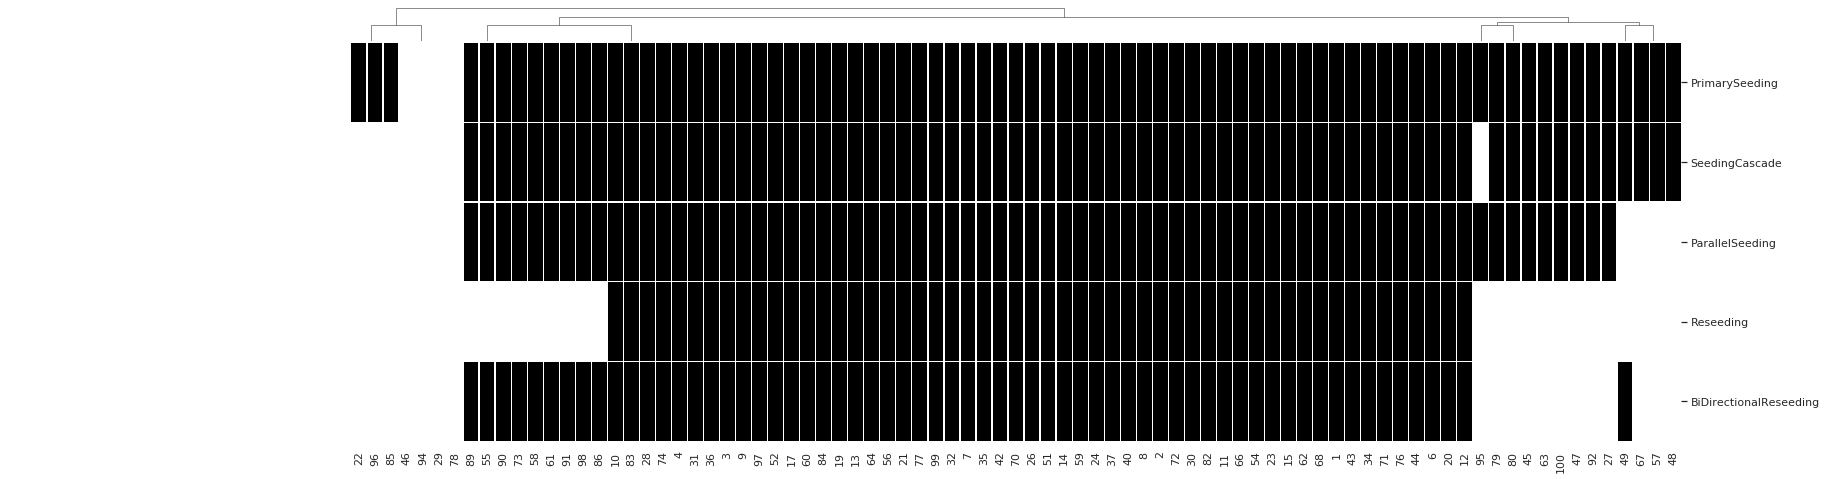

In [53]:
topo_df = pd.read_csv("lineage_topology.5k.txt", sep='\t', index_col = 0)

sns.set(font_scale=1)
# topo_df = topo_df.iloc[:, :5]
cm = sns.clustermap(topo_df.T, cmap = 'Greys', row_cluster=False, figsize = (30, 8), linewidths=.25)
cm.cax.set_visible(False) 

plt.savefig('lineage_topology.5k.eps')

## Summarize transition matrices

In [57]:
# unravel and drop diagonal values
transition_vectors = []
lgs = []
k = 0
for lg, tm in lg_to_countarr.items():
    tv = []
        
    lgs.append(lg)
    for i in range(tm.shape[0]):
        for j in range(tm.shape[1]):
            if i != j:    
                tv.append(tm.iloc[i, j])
    tv.append(np.sum(tm['LL'].values))
    tv.append(np.sum(tm[['M1', 'M2']].sum()))
    tv.append(np.sum(tm['Liv'].values))
    tv.append(np.sum(tm.loc['LL', ['RW', 'RE']].sum()))
    tv.append(np.sum(tm.loc[['RE', 'RW'], 'LL'].sum()))
    tv.append(np.sum(tm.loc[['LL', "RE", "RW"], ['LL', 'RE', 'RW']].sum()))
    tv.append(np.sum(tm.loc[['M1', 'M2'], ['M1', 'M2']].sum()))
    tv.append(np.sum(tm[['RE', 'RW']].sum()))
    tv.append(LL_density[k])
    tv.append(M1_density[k])
    tv.append(M2_density[k])
    tv.append(M1_density[k] + M2_density[k])
    
    transition_vectors.append(np.nan_to_num(tv))
    
    k += 1

tmat = np.array(transition_vectors)

trans_labels = []
toy = lg_to_countarr[1]
for i in range(toy.shape[0]):
    for j in range(toy.shape[1]):
        if i != j:
            trans_labels.append(toy.index.values[i] + "->" + toy.columns.values[j])
            
trans_labels.append("LLReseeding")
trans_labels.append("To_M")
trans_labels.append('To_Liv')
trans_labels.append('LL_to_RL')
trans_labels.append("RL_to_LL")
trans_labels.append("IntraLung")
trans_labels.append('IntraM')
trans_labels.append('ToRL')
trans_labels.append("PrimarySeeding")
trans_labels.append("FromM1")
trans_labels.append("FromM2")
trans_labels.append("FromMed")

tmat = pd.DataFrame(tmat)

tmat_z = tmat \
    .subtract(tmat.mean(axis=1), axis=0) \
    .divide(tmat.std(axis=1), axis=0)

tmat_z = np.nan_to_num(tmat_z)

pca = PCA()
tmat_transformed = pca.fit_transform(tmat_z)

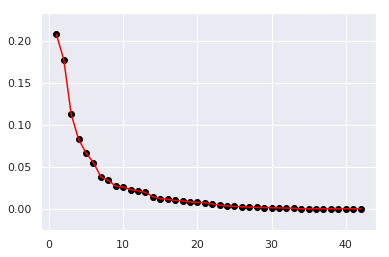

In [58]:
loadings = np.transpose(pca.components_[0:2, :])
var_explained = pca.explained_variance_ratio_

plt.scatter(np.arange(1, len(var_explained)+1), var_explained, color='black')
plt.plot(np.arange(1, len(var_explained)+1), var_explained, color='red')
plt.show()

pc1_top_loading = np.argmax(loadings[:,0])
pc2_top_loading = np.argmax(loadings[:,1])

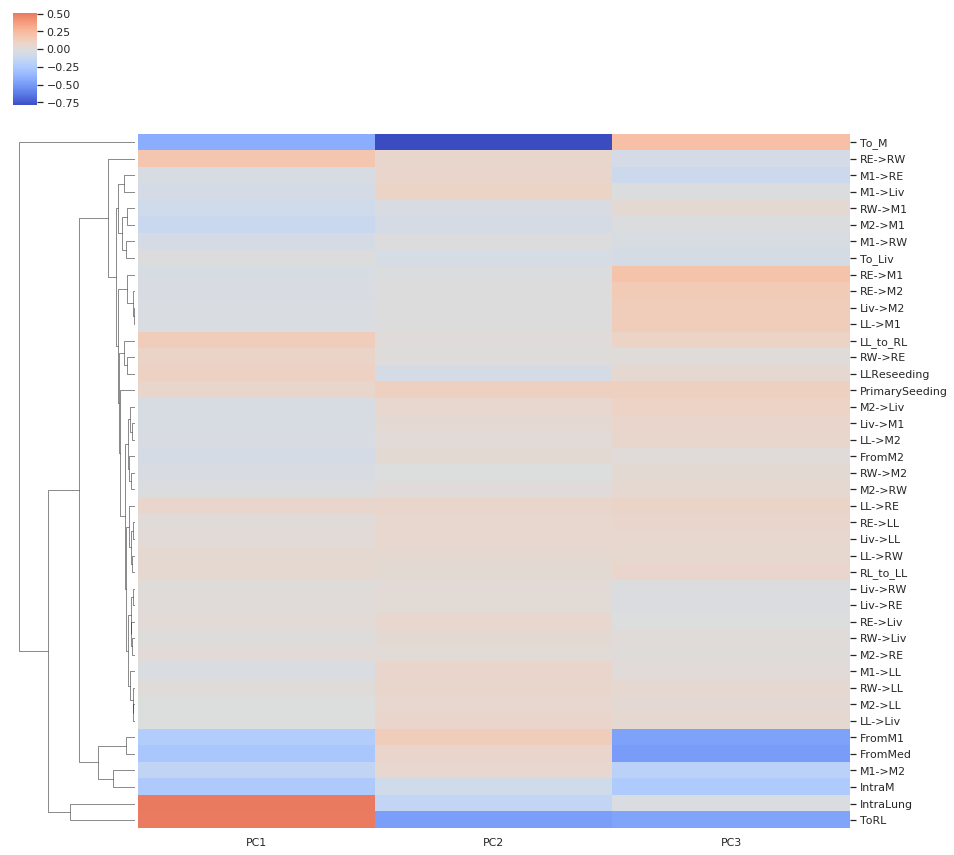

(42, 42)


,PC1,PC2,PC3
To_M,-0.402460,-0.793101,0.221038
FromMed,-0.259463,0.074164,-0.485381
IntraM,-0.248273,-0.078898,-0.239829
FromM1,-0.224322,0.133758,-0.458622
M1->M2,-0.152671,0.063957,-0.182952
M2->M1,-0.110613,-0.046871,-0.005150
RW->M1,-0.078638,-0.024914,0.042653
M1->Liv,-0.052605,0.096389,-0.007206
FromM2,-0.050152,0.036390,0.024968
M1->RW,-0.048612,0.004614,-0.039508


In [65]:
coeff = np.transpose(pca.components_)
coeffdf = pd.DataFrame(coeff, index=trans_labels)
coeffdf.columns = ["PC" + str(x + 1) for x in range(coeff.shape[1])]

cm = sns.clustermap(coeffdf.iloc[:, :3], cmap = 'coolwarm', col_cluster=False, figsize = (15, 15), center=0)
# cm.cax.set_visible(False)
#plt.tight_layout()
plt.savefig('transmatpca_loadings.withcolorbar.eps')
plt.show()

print(coeffdf.shape)
coeffdf.iloc[:,:3].sort_values(by = 'PC1')

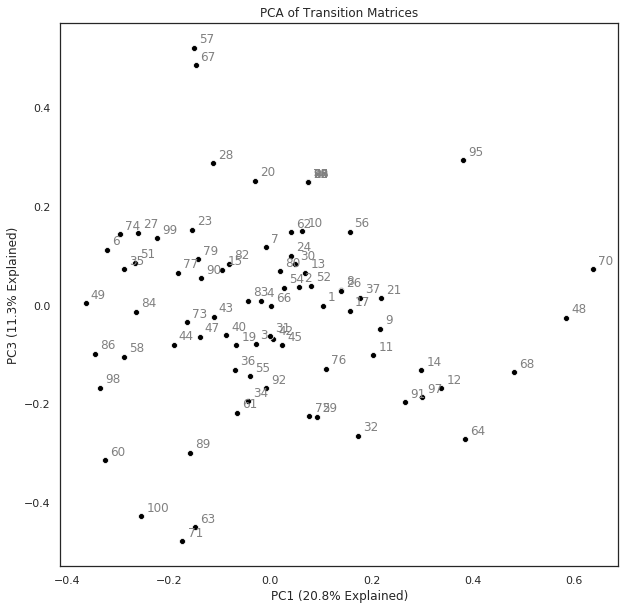

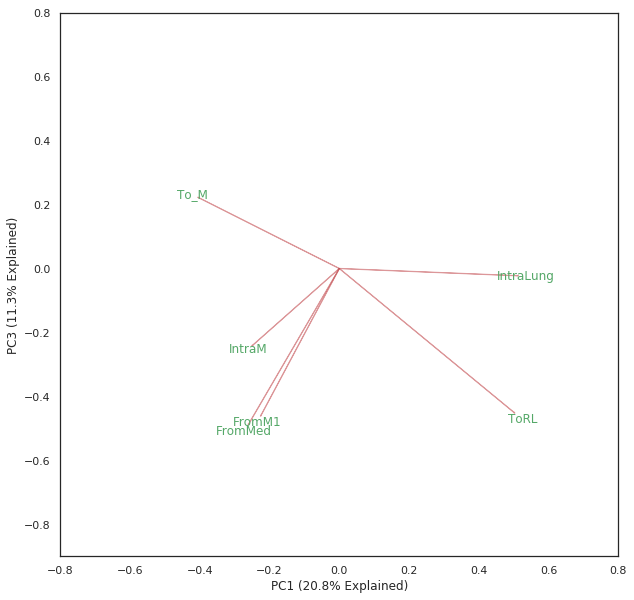

In [70]:
d1, d2 = 0, 2

sns.set_style("white")

x, y = tmat_transformed[:,d1], tmat_transformed[:, d2]
sizes = dict(zip(lgs, x))
ss = dict(zip(lgs, y))
labs = lgs

scalex = 1.0/(x.max() - x.min())
scaley = 1.0/(y.max() - y.min())

h = plt.figure(figsize = (10, 10))
ax = sns.scatterplot(x*scalex, y*scaley, color='black')
plt.title("PCA of Transition Matrices")


for i in labs:
    plt.annotate(i, (sizes[i]*scalex+0.01, ss[i]*scaley+0.01), color='grey')

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))
plt.savefig('transmatpca_pc{}_{}.eps'.format(d1+1, d2+1))
plt.show()


h = plt.figure(figsize = (10, 10))
coeff = np.transpose(pca.components_)

iis = np.argsort(np.abs(coeff[:, d1]))[::-1][:5]
iis = np.unique(np.concatenate((iis, np.argsort(np.abs(coeff[:, d2]))[::-1][:5])))
for i in iis:
    plt.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = 'r',alpha = 0.5)
    plt.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, trans_labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.9, 0.8)

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))

# plt.savefig('biplot_transmat.pc{}_{}.eps'.format(d1+1, d2+1))

plt.show()

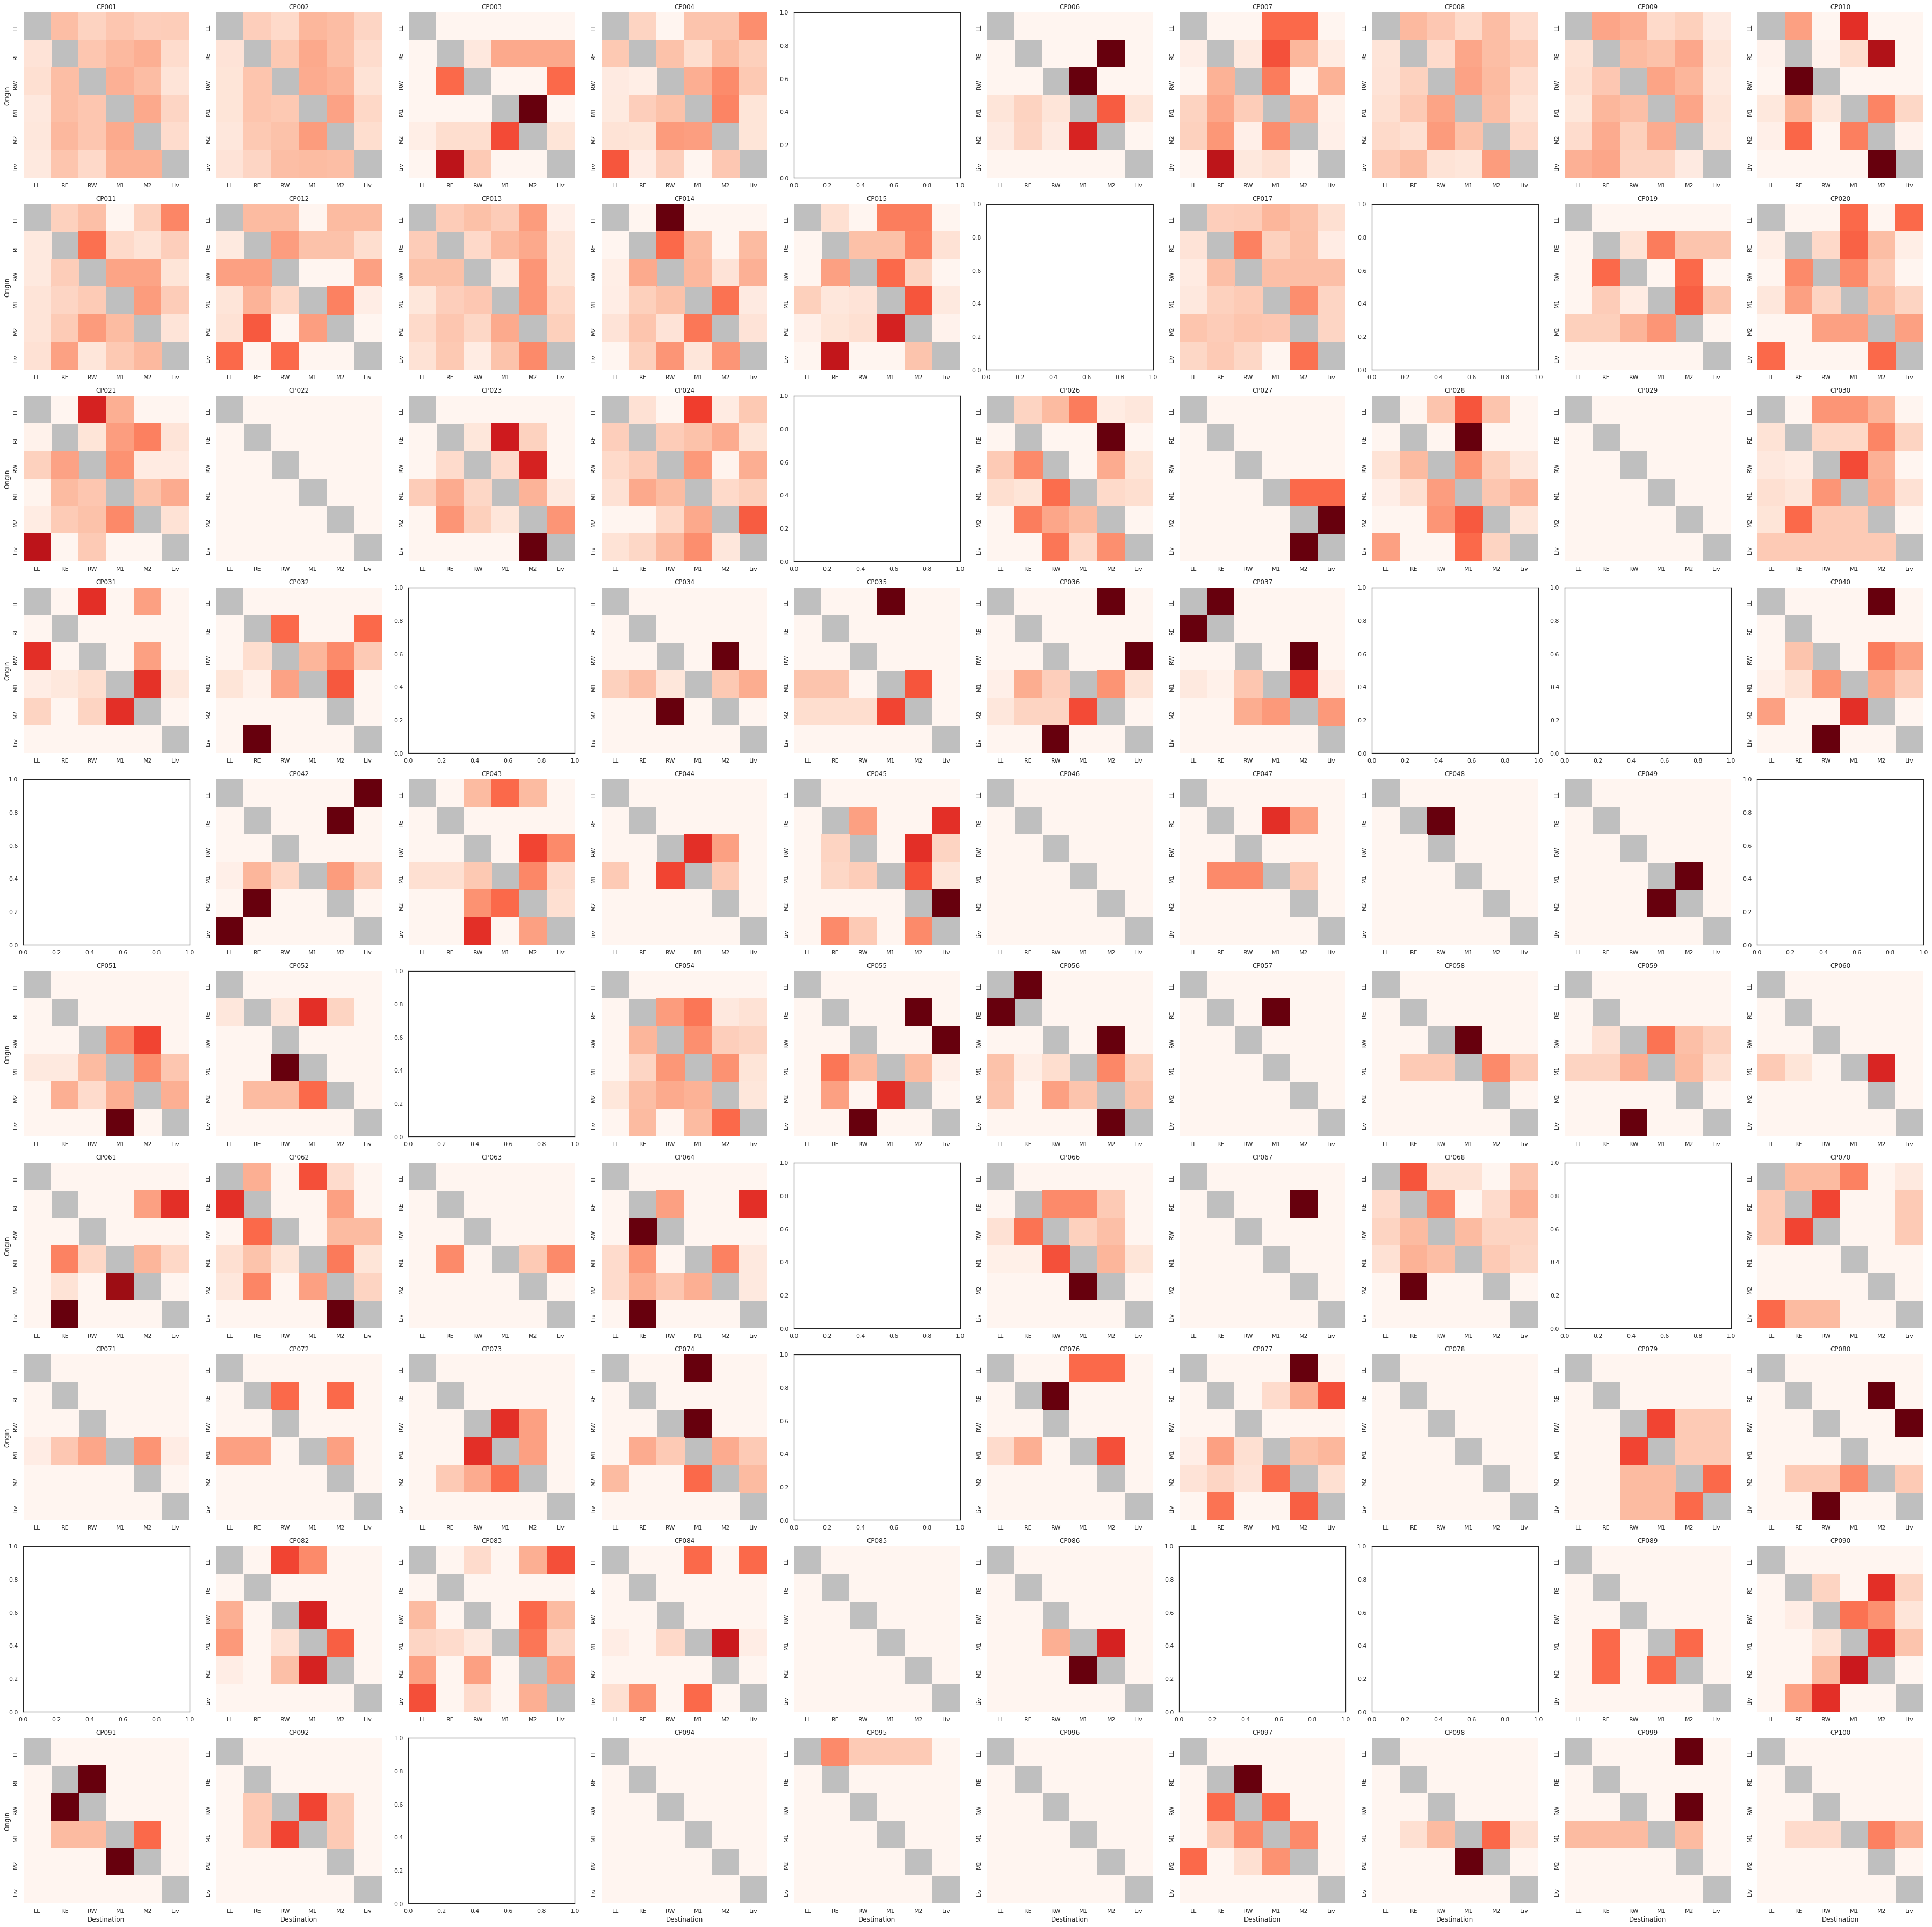

In [73]:
# generate all transition matrices 
fig, axarr = plt.subplots(nrows = 10, ncols=10, figsize = (50, 50))
mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)


for j in range(1, 101):
    
    if j not in lg_to_countarr:
        continue
        
    x = int((j-1)/10)
    y = int((j-1)%10)
    
    
    res = lg_to_countarr[j].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
    g = sns.heatmap(res, mask = mask, cmap="Reds", ax=axarr[x, y], square=True, vmin = 0, vmax=1.0, cbar=False)
    # remove colorbar
    if y == 0:
        axarr[x,y].set_ylabel("Origin")
    if x == 9:
        axarr[x,y].set_xlabel("Destination")
    
    # add CP annotation
    if j < 10:
        axarr[x,y].set_title('CP00' + str(j))
    elif j < 100:
        axarr[x,y].set_title('CP0' + str(j))
    else:
        axarr[x,y].set_title('CP' + str(j))
    g.set_facecolor('#bfbfbf')
    
plt.subplots_adjust(hspace=0.7, wspace=0.1)
plt.tight_layout()
# plt.savefig('all_clone_transmat.eps')
plt.show()

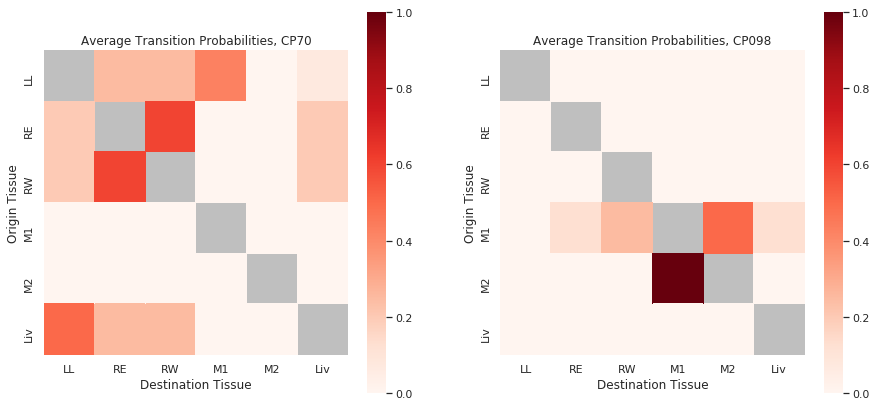

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)

lg1 = 70


res = lg_to_countarr[lg1].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
g = sns.heatmap(res, mask = mask, cmap="Reds", ax=axes[0], square=True, vmin = 0, vmax=1.0)
axes[0].set_ylabel("Origin Tissue")
axes[0].set_xlabel("Destination Tissue")
axes[0].set_title("Average Transition Probabilities, CP" + str(lg1))
g.set_facecolor('#bfbfbf')

lg2 = 98

res = lg_to_countarr[lg2].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
g = sns.heatmap(res, mask = mask, 
                cmap="Reds", ax=axes[1], square=True, vmin=0, vmax=1.0)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Average Transition Probabilities, CP0" + str(lg2))
g.set_facecolor('#bfbfbf')

plt.savefig("cp{}_cp{}_tmat.eps".format(str(lg1), str(lg2)))


### Example for computing a subtree's transition matrix

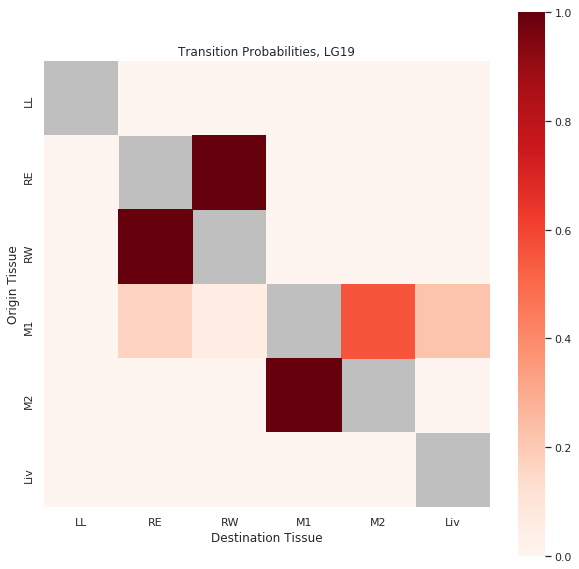

In [34]:
import cassiopeia.TreeSolver.utilities as util 

lg = lg_to_tree[19]
cm = lg_to_cm[19]

def get_leaves(tree, x):
    
    all_prog = [node for node in nx.dfs_preorder_nodes(tree, x)]
    return [n.name for n in all_prog if tree.out_degree(n) == 0 and tree.in_degree(n) == 1]
    
plg = lg.post_process(cm).network

c1 = "M2.GTGAAGGAGCTGTCTA-1"
c2 = "M2.TGCACCTCACTACAGT-1"
c3 = "M2.TCACAAGTCGGCTACG-1"
c4 = "RE.GATGAAAAGTAGCCGA-1"

root = [n for n in plg if plg.in_degree(n) == 0][0]
subns = []
plg2 = nx.DiGraph()
for child in plg.successors(root):
    all_children = get_leaves(plg, child)
    if c1 in all_children or c2 in all_children or c3 in all_children or c4 in all_children:
        subn = plg.subgraph([node for node in nx.dfs_preorder_nodes(plg, child)])
        plg2 = nx.compose(plg2, subn)

pseudo_roots = [n for n in plg2 if plg2.in_degree(n) == 0]
plg2.add_edges_from([(root, pr) for pr in pseudo_roots])

nw = util.convert_network_to_newick_format(plg2)
with open('sublg19_tree.nwk', 'w') as f:
    f.write(nw)

leaves = [n for n in plg2 if plg2.out_degree(n) == 0]

count_arr = reconstruct_states.fitch_count(plg2, lg_meta['sampleID'])
np.fill_diagonal(count_arr.values,0)

mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)

count_arr = count_arr.apply(lambda x: x / max(1, x.sum()), axis=1)
res = count_arr.loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
h = plt.figure(figsize=(10, 10))
np.fill_diagonal(count_arr.values,np.nan)
g = sns.heatmap(res, mask = mask, cmap="Reds",  square=True)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Transition Probabilities, LG" + str(19))
g.set_facecolor('#bfbfbf')
plt.savefig('cp019_sub_tmat.eps')
plt.show()